In [21]:
# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import numpy as np
import holodeck as holo
import holodeck.single_sources as ss
import holodeck.cyutils as cy
import matplotlib.pyplot as plt
from holodeck import utils
import kalepy as kale
from holodeck import utils, plot
from holodeck.constants import YR, MSOL

loudest_by_cdefs

In [ ]:
#  IN PROGRESS
def loudest_by_cdefs(edges, number, realize, loudest = 1, round = True):
       
    """ Calculate characteristic strain from background and a number of individual single sources.


    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M+1, Q+1, Z+1, F+1.
    number : (M, Q, Z, F) ndarray of scalars
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    loudest : int
        Number, L, of loud sources to separate at each frequency.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. 
        Does nothing if realize is True.
    

    Returns
    -------
    hc_bg : (F, R) NDarray of scalars
        Characteristic strain of the GWB.
        just (F,) if realize = True or False.
    hc_ss : (F, R) NDarray of scalars
        The characteristic strain of the loudest single source at each frequency.
        just (F,) if realize = True or False.
    ssidx : (3, L, F, R) NDarray
        The indices of loudest single sources at each frequency of each realization.
        just (3,F,) if realize = True or False.
    hsamp : (M, Q, Z, F) NDarray
        Strain amplitude of a single source in every bin (regardless of if that bin
        actually has any sources.)
    bgpar : (3, F, R) NDarray of scalars
        Average effective binary astrophysical parameters for background
        sources at each frequency and realization.
        Returned only if params = True.
    sspar : (3, L, F, R) NDarray of scalars
        Astrophysical parametes of loudest sources at each frequency
        for each realizations.
        Returned only if params = True.
    

    In the unlikely scenario that there are two equal hsmaxes 
    (at same OR dif frequencies), ssidx calculation will go wrong
    Could avoid this by using argwhere for each f_idx column separately.
    Or TODO implement some kind of check to see if any argwheres return multiple 
    values for that hsmax and raises a warning/assertion error

    """

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)
    F = len(fc)                       #: number of frequencies

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses --- in shape (M, Q) 
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])

    # --- Comoving Distances --- in shape (Z)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value

    # --- Rest Frame Frequencies --- in shape (Z, F) 
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])

    # --- Source Strain Amplitude --- in shape (M, Q, Z, F) 
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    # hsfdf = hsamp^2 * f/df
    h2fdf = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                    /df[np.newaxis, np.newaxis, np.newaxis,:]) 

    # For multiple realizations, using cython
    if(utils.isinteger(realize)): 
        hc2ss, hc2bg = holo.cyutils.loudest_hc(number, h2fdf, realize, loudest, mt, mr, rz)
        hc_ss = np.sqrt(hc2ss)
        hc_bg = np.sqrt(hc2bg)
        return hc_bg, hc_ss
    
    # OTHERWISE
    elif(realize==False):
        print('realize = False not implemented for multiple loud sources.')
        if (round == True):
            bgnum = np.copy(np.floor(number).astype(np.int64))
            assert (np.all(bgnum%1 == 0)), 'non integer numbers found with round=True'
            assert (np.all(bgnum >= 0)), 'negative numbers found with round=True'
        else:
            bgnum = np.copy(number)
            warnings.warn('Number grid used for single source calculation.')
    elif(realize == True):
        print('realize = True not implemented for multiple loud sources.')
        bgnum = np.random.poisson(number)
        assert (np.all(bgnum%1 ==0)), 'nonzero numbers found with realize=True'
    else:
        raise Exception("`realize` ({}) must be one of {{True, False, integer}}!"\
                            .format(realize))

    # --- Single Source Characteristic Strain --- in shape (F,)
    hc_ss = np.sqrt(np.amax(h2fdf, axis=(0,1,2)))

    # --- Indices of Loudest Bin --- in shape (3, F)
    # looks like [[m1,m2,..mF], [q1,q2,...qF], [z1,z2,...zF]]
    htemp = np.copy(hsamp) #htemp is s same as hsamp except 0 where bgnum=0
    htemp[(bgnum==0)] = 0
    shape = htemp.shape
    # print('shape', shape)
    newshape = (shape[0]*shape[1]*shape[2], shape[3])
    htemp = htemp.reshape(newshape) # change hsamp to shape (M*Q*Z, F)
    argmax = np.argmax(htemp, axis=0) # max at each frequency
    # print('argmax', argmax)
    ssidx = np.array(np.unravel_index(argmax, shape[:-1])) # unravel indices
    # print('ssidx', ssidx)

    # --- Background Characteristic Strain --- in shape (F,) 
    hc_bg = np.sqrt(np.sum(bgnum*h2fdf, axis=(0,1,2)))
    return hc_bg, hc_ss, ssidx, hsamp


In [ ]:
edges, number, fobs, exname = ss.example5()

In [ ]:
hc2ss, hc2bg = cy.loudest_hc(number, h2fdf, 10, 5, mt, mr, rz)
hc_ss = np.sqrt(hc2ss)
hc_bg = np.sqrt(hc2bg)

loudest_by_cdef_slow
not working

In [10]:
#  IN PROGRESS
def loudest_by_cdefs_slow(edges, number, realize, loudest = 1, round = True):
       
    """ Calculate characteristic strain from background and a number of individual single sources.


    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M+1, Q+1, Z+1, F+1.
    number : (M, Q, Z, F) ndarray of scalars
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    louds : int
        Number, L, of loud sources to separate at each frequency.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. 
        Does nothing if realize is True.
    

    Returns
    -------
    hc_bg : (F, R) NDarray of scalars
        Characteristic strain of the GWB.
        just (F,) if realize = True or False.
    hc_ss : (F, R) NDarray of scalars
        The characteristic strain of the loudest single source at each frequency.
        just (F,) if realize = True or False.
    ssidx : (3, L, F, R) NDarray
        The indices of loudest single sources at each frequency of each realization.
        just (3,F,) if realize = True or False.
    hsamp : (M, Q, Z, F) NDarray
        Strain amplitude of a single source in every bin (regardless of if that bin
        actually has any sources.)
    bgpar : (3, F, R) NDarray of scalars
        Average effective binary astrophysical parameters for background
        sources at each frequency and realization.
        Returned only if params = True.
    sspar : (3, L, F, R) NDarray of scalars
        Astrophysical parametes of loudest sources at each frequency
        for each realizations.
        Returned only if params = True.
    

    In the unlikely scenario that there are two equal hsmaxes 
    (at same OR dif frequencies), ssidx calculation will go wrong
    Could avoid this by using argwhere for each f_idx column separately.
    Or TODO implement some kind of check to see if any argwheres return multiple 
    values for that hsmax and raises a warning/assertion error

    """

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)
    F = len(fc)                       #: number of frequencies

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses --- in shape (M, Q) 
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])

    # --- Comoving Distances --- in shape (Z)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value

    # --- Rest Frame Frequencies --- in shape (Z, F) 
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])

    # --- Source Strain Amplitude --- in shape (M, Q, Z, F) 
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    # hsfdf = hsamp^2 * f/df
    h2fdf = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                    /df[np.newaxis, np.newaxis, np.newaxis,:]) 

    # For multiple realizations, using cython
    if(utils.isinteger(realize)): 
        hc2ss, hc2bg = holo.cyutils.loudest_hc_slow(number, h2fdf, realize, loudest, mt, mr, rz)
        hc_ss = np.sqrt(hc2ss)
        hc_bg = np.sqrt(hc2bg)
        return hc_bg, hc_ss
    
    # OTHERWISE
    elif(realize==False):
        print('realize = False not implemented for multiple loud sources.')
        if (round == True):
            bgnum = np.copy(np.floor(number).astype(np.int64))
            assert (np.all(bgnum%1 == 0)), 'non integer numbers found with round=True'
            assert (np.all(bgnum >= 0)), 'negative numbers found with round=True'
        else:
            bgnum = np.copy(number)
            warnings.warn('Number grid used for single source calculation.')
    elif(realize == True):
        print('realize = True not implemented for multiple loud sources.')
        bgnum = np.random.poisson(number)
        assert (np.all(bgnum%1 ==0)), 'nonzero numbers found with realize=True'
    else:
        raise Exception("`realize` ({}) must be one of {{True, False, integer}}!"\
                            .format(realize))

    # --- Single Source Characteristic Strain --- in shape (F,)
    hc_ss = np.sqrt(np.amax(h2fdf, axis=(0,1,2)))

    # --- Indices of Loudest Bin --- in shape (3, F)
    # looks like [[m1,m2,..mF], [q1,q2,...qF], [z1,z2,...zF]]
    htemp = np.copy(hsamp) #htemp is s same as hsamp except 0 where bgnum=0
    htemp[(bgnum==0)] = 0
    shape = htemp.shape
    # print('shape', shape)
    newshape = (shape[0]*shape[1]*shape[2], shape[3])
    htemp = htemp.reshape(newshape) # change hsamp to shape (M*Q*Z, F)
    argmax = np.argmax(htemp, axis=0) # max at each frequency
    # print('argmax', argmax)
    ssidx = np.array(np.unravel_index(argmax, shape[:-1])) # unravel indices
    # print('ssidx', ssidx)

    # --- Background Characteristic Strain --- in shape (F,) 
    hc_bg = np.sqrt(np.sum(bgnum*h2fdf, axis=(0,1,2)))
    return hc_bg, hc_ss, ssidx, hsamp


In [38]:
edges, number, fobs, exname = ss.example5()
h2fdf = ss.h2fdf(edges)
mt = kale.utils.midpoints(edges[0]) #: total mass
mr = kale.utils.midpoints(edges[1]) #: mass ratio
rz = kale.utils.midpoints(edges[2]) #: redshift


Number of frequency bins: 24
  between [0.10, 2.50] 1/yr
          [3.17, 79.22] nHz
using default mtot, mrat, and redz
edges: [array([1.98840987e+37, 2.60119300e+37, 3.40282209e+37, 4.45149521e+37,
       5.82334576e+37, 7.61796975e+37, 9.96565642e+37, 1.30368473e+38,
       1.70545099e+38, 2.23103257e+38, 2.91858655e+38, 3.81802918e+38,
       4.99465977e+38, 6.53390141e+38, 8.54750264e+38, 1.11816504e+39,
       1.46275832e+39, 1.91354748e+39, 2.50325972e+39, 3.27470797e+39,
       4.28389920e+39, 5.60410044e+39, 7.33115796e+39, 9.59045570e+39,
       1.25460181e+40, 1.64124183e+40, 2.14703559e+40, 2.80870360e+40,
       3.67428278e+40, 4.80661396e+40, 6.28790411e+40, 8.22569452e+40,
       1.07606683e+41, 1.40768639e+41, 1.84150362e+41, 2.40901356e+41,
       3.15141727e+41, 4.12261308e+41, 5.39310957e+41, 7.05514445e+41,
       9.22938105e+41, 1.20736684e+42, 1.57945010e+42, 2.06620105e+42,
       2.70295767e+42, 3.53594833e+42, 4.62564796e+42, 6.05116846e+42,
       7.91600228e+4

In [5]:
hc_bg, hc_ss, hsamp = loudest_by_cdefs(edges, number, realize=10, loudest=5)

: 

: 

In [27]:
h2fdf = ss.h2fdf(edges)
mt = kale.utils.midpoints(edges[0]) #: total mass
mr = kale.utils.midpoints(edges[1]) #: mass ratio
rz = kale.utils.midpoints(edges[2]) #: redshift


In [28]:
hc2ss, hc2bg = cy.loudest_hc_slow(number, h2fdf, 10, 5, mt, mr, rz)
hc_ss = np.sqrt(hc2ss)
hc_bg = np.sqrt(hc2bg)

In [37]:
print(hc_bg[0])

[nan nan nan nan nan nan nan nan nan nan]


In [29]:
print(hc_ss.shape)

(25, 10, 5)


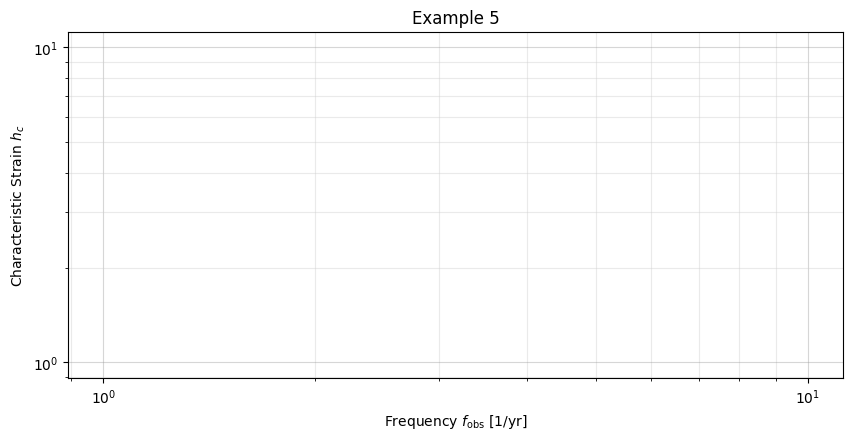

In [36]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR

# for ll in range(len(hc_ss[0,0])):
#     ss.plot_samples(ax, xx, BG=hc_bg, SS=None,
#                     REALS = 2)
plt.plot(xx, hc_bg[:,0])


multiple_by_ndars

In [6]:
def loudest_by_ndars(edges, number, realize, loudest = 1, round = True):
       
    """ More efficient way to calculate strain from numbered 
    grid integrated


    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M+1, Q+1, Z+1, F+1.
    number : (M, Q, Z, F) ndarray of scalars
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    louds : int
        Number, L, of loud sources to separate at each frequency.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. 
        Does nothing if realize is True.
    
    Returns
    -------
    hc_bg : (F, R) ndarray of scalars
        Characteristic strain of the GWB.
        If realize = True or False: R is 1
        If realize is an integer, R=realize
    hc_ss : (F, R) ndarray of scalars
        The characteristic strain of the loudest single source at each frequency.
    hsamp : (M, Q, Z, F, R) ndarray
        Strain amplitude of a single source in every bin (but equal to zero 
        if the number in that bin is 0)
    ssidx : (5, L, F, R) ndarray
        The indices of loudest single sources at each frequency of each realization
        in the format: [[M indices], [q indices], [z indices], [f indices], [r indices]] 
    hsmax : (L, F, R) array of scalars 
        The maximum single source strain amplitude at each frequency.
    bgnum : (M, Q, Z, F, R) ndarray
        The number of binaries in each bin after the loudest single source
        at each frequency is subtracted out.
    

    In the unlikely scenario that there are two equal hsmaxes 
    (at same OR dif frequencies), ssidx calculation will go wrong
    Could avoid this by using argwhere for each f_idx column separately.
    Or TODO implement some kind of check to see if any argwheres return multiple 
    values for that hsmax and raises a warning/assertion error

    """

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)
    F = len(fc)                       #: number of frequencies

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses ---
    # to get chirp mass in shape (M, Q) we need 
    # mt in shape (M, 1) 
    # mr in shape (1, Q)
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])

    # --- Comoving Distances ---
    # to get cdist in shape (Z) we need
    # rz in shape (Z)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value

    # --- Rest Frame Frequencies ---
    # to get rest freqs in shape (Z, F) we need 
    # rz in shape (Z, 1) 
    # fc in shape (1, F)
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])

    # --- Source Strain Amplitude ---
    # to get hs amplitude in shape (M, Q, Z, F) we need
    # cmass in shape (M, Q, 1, 1) from (M, Q)
    # cdist in shape (1, 1, Z, 1) from (Z)
    # rfreq in shape (1, 1, Z, F) from (Z, F)
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])


    ########## HERE'S WHERE THINGS CHANGE FOR SS ###############

    # --------------- Single Sources ------------------
    ##### 0) Round and/or realize so numbers are all integers

    # --- Background Number ---
    # in shape (M, Q, Z, F, R)
    if(realize == False):
        R=1
        if (round == True):
            bgnum = np.copy(np.floor(number).astype(np.int64))[...,np.newaxis]
            assert (np.all(bgnum%1 == 0)), 'non integer numbers found with round=True'
            assert (np.all(bgnum >= 0)), 'negative numbers found with round=True'
        else:
            bgnum = np.copy(number)[...,np.newaxis]
    elif(realize == True):
        R=1
        bgnum = np.random.poisson(number[...,np.newaxis], 
                                size = (number.shape + (R,)))
        assert (np.all(bgnum%1 ==0)), 'nonzero numbers found with realize=True'
    elif(utils.isinteger(realize)):
        R=realize
        bgnum = np.random.poisson(number[...,np.newaxis], 
                                size = (number.shape + (R,)))
    else:
        print("`realize` ({}) must be one of {{True, False, integer}}!"\
            .format(realize))   

    #### 1) Identify the loudest (max hs) single source in a bin with N>0 
    # NOTE this requires hsamp for every realization, might be slow/big
    # --- Bin Strain Amplitudes ---
    # to get hsamp in shape (M, Q, Z, F, R)
    # hsamp = np.repeat(hsamp[...,np.newaxis], R, axis=4)
    # hsamp[(bgnum==0)] = 0 #set hs=0 if number=0
    # hsamp[bgnum==0] = 0


    # get an array that couples each bin's amaplitude and number, 
    # then sort them by the amplitude for each frequency and realization
    hsort = np.array([hsamp, bgnum])
    shape = hsort.shape
    hsort = hsort.reshape((shape[0], shape[1]*shape[2]*shape[3], shape[4], shape[5]))  # sort the amplitude from all bins  at a 
    hsort = np.sort(hsort, axis=1) #amplitudes of 


    # pop off loudest sources
    maxes = np.zeros(loudest, len(fc), realize)
    

        if count==loudest: break
    

    # how to sort two arrays by one? like to couple them
        
    # --- Single Source Strain Amplitude At Each Frequency ---
    # to get max strain in shape (F) we need
    # hsamp in shape (M, Q, Z, F), search over first 3 axes
    hsmax[l_idx] = np.amax(hsamp, axis=(0,1,2)) #find max hs at each frequency
    

    #### 2) Record the indices and strain of that single source

    # --- Indices of Loudest Bin ---
    # Shape (5, F, R), 
    # where ssidx[:,F,R] = m, q, z, f, r indices for loudest source at F, R
    shape = hsamp.shape
    newshape = (shape[0]*shape[1]*shape[2], shape[3], shape[4])
    hsamp = hsamp.reshape(newshape) # change hsamp to shape (M*Q*Z, F, R)
    argmax = np.argmax(hsamp, axis=0) # max at each frequency
    hsamp = hsamp.reshape(shape) # restore hsamp shape to (M, Q, Z, F, R)
    mqz = np.array(np.unravel_index(argmax, shape[:-2]))         # shape (3, F, R)
    # add frequency indices
    f_ids = np.arange(len(mqz[0])).astype(int) # shape (F)
    f_ids = np.repeat(f_ids, R).reshape(F, R)[np.newaxis,...]    # shape (1, F, R)
    ssidx = np.append(mqz, f_ids, axis=0)                        # shape (4, F, R)
    # add realization indices
    r_ids = np.arange(R).astype(int)                     # shape (R)
    r_ids = np.tile(r_ids, F).reshape(F,R)[np.newaxis,...]       # shape (1, F, R)
    ssidx = np.append(ssidx, r_ids, axis=0)                      # shape (5, F, R)



    #### 3) Subtract 1 from the number in that source's bin

    # --- Background Number ---
    # bgnum = subtract_from_number(bgnum, ssidx) # Find a better way to do this!
    if np.any( bgnum[(hsamp == hsmax)] <=0):
        raise Exception("bgnum <= found at hsmax")
    if np.any( hsamp[(hsamp == hsmax)] <=0):
        raise Exception("hsamp <=0 found at hsmax")
    if np.any(hsmax<=0):
        raise Exception("hsmax <=0 found")
   
    # print('bgnum stats:\n', holo.utils.stats(bgnum))
    # print('bgnum[hsamp==hsmax] stats:\n', holo.utils.stats(bgnum[(hsamp == hsmax)]))
    # print('ssidx\n', ssidx, ssidx.shape)
    bgnum[ssidx[0], ssidx[1], ssidx[2], ssidx[3], ssidx[4]] -= 1
    # print('\nafter subtraction')
    # print('bgnum stats:\n', holo.utils.stats(bgnum))
    # print('bgnum[hsamp==hsmax] stats:\n', holo.utils.stats(bgnum[(hsamp == hsmax)]))

    assert np.all(bgnum>=0), f"bgnum contains negative values at: {np.where(bgnum<0)}"
    

    #### 4) Calculate single source characteristic strain (hc)

    # --- Single Source Characteristic Strain ---
    # to get ss char strain in shape [F,R] need
    # fc in shape (F,1)
    # df in shape (F,1)
    # hsmax in shape (F,R)
    hc_ss = np.sqrt(hsmax**2 * (fc[:,np.newaxis]/df[:,np.newaxis]))


    
    #### 5) Calculate the background with the new number 
 
    # --- Background Characteristic Strain Squared ---
    # to get characteristic strain in shape (M, Q, Z, F, R) we need
    # hsamp in shape (M, Q, Z, F, R)
    # fc in shape (1, 1, 1, F, 1)
    hchar = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:,np.newaxis]
                        /df[np.newaxis, np.newaxis, np.newaxis,:,np.newaxis])   
    hchar *= bgnum

        

    # --- Background Characteristic Strain  ---
    # hc_bg in shape (F, R)
    hchar = np.sum(hchar, axis=(0, 1, 2)) # sum over all bins at a given frequency
    hc_bg = np.sqrt(hchar) # sqrt

    return hc_bg, hc_ss, hsamp, ssidx, hsmax, bgnum


IndentationError: unexpected indent (3058065932.py, line 136)

Bad cyutils function


def multiple_hc_and_par(number, h2fdf, nreals, nloudest, mt, mr, rz, normal_threshold=1e10):
    """
    Calculates the characteristic strain from loud single sources and a background of all other sources.

    Parameters
    ------------------------
    number : [M, Q, Z, F] NDarray
        number in each bin
    h2fdf : [M, Q, Z, F] NDarray
        Strain amplitude squared x frequency / frequency bin width for each bin.
    nreals
        Number of realizations.
    nloudest
        Number of loudest sources to separate in each frequency bin.
    mt : (M,) 1Darray of scalars
        Total masses, M, of each bin center.
    mr : (Q,) 1Darray of scalars
        Mass ratios, q, of each bin center.
    rz : (Z,) 1Darray of scalars
        Redshifts, z, of each bin center.

    Returns
    --------------------------
    hc2ss : (F, R) Ndarray of scalars
        Char strain squared of the loudest single sources.
    hc2bg : (F, R) Ndarray of scalars
        Char strain squared of the background.
    ssidx : (3, L, F, R) NDarray of ints
        Indices of the loudest single sources.
    bgpar : (3, F, R) NDarray of scalars
        Average effective M, q, z parameters of the background.
    lspar : (3, L, F, R) NDarray of scalars
        M, q, z parameters of the L loudest sources.
    """

    cdef long[:] shape = np.array(number.shape)
    F = shape[3]
    R = nreals
    cdef np.ndarray[np.double_t, ndim=2] hc2ss = np.zeros((F,R))
    cdef np.ndarray[np.double_t, ndim=2] hc2bg = np.zeros((F,R))
    cdef np.ndarray[np.long_t, ndim=3] ssidx = np.zeros((3,F,R), dtype=int)
    cdef np.ndarray[np.double_t, ndim=3] bgpar = np.zeros((3,F,R))
    cdef np.ndarray[np.double_t, ndim=3] lspar = np.zeros((3,F,R))
    _ss_bg_hc_and_par(shape, h2fdf, number, nreals, normal_threshold, 
                 mt, mr, rz,
                hc2ss, hc2bg, ssidx, bgpar, lspar)
    return hc2ss, hc2bg, ssidx, bgpar, lspar
    
@cython.boundscheck(True)
@cython.wraparound(True)
@cython.nonecheck(True)
@cython.cdivision(True)
cdef void _multiple_hc_and_par(long[:] shape, double[:,:,:,:] h2fdf, double[:,:,:,:] number,
            long nreals, long nloudest, long thresh,
            double[:] mt, double[:] mr, double[:] rz,
            double[:,:] hc2ss, double[:,:] hc2bg, long[:,:,:,:] ssidx, 
            double[:,:,:] bgpar, double[:,:,:,:] lspar):
    """
    Calculates the characteristic strain from loud single sources and a background of all other sources.

    Parameters
    __________
    shape : long[:] array
        Shape of number, [M, Q, Z, F].
    number : double[:,:,:,:] array
        Number per bin.
    h2fdf : double[:,:,:,:] array
        Strain amplitude squared * f/Delta f for a single source in each bin.
    nreals : int
        Number of realizations.
    nloudest : int
        Number of loudest sources at each source.
    mt : (M,) 1Darray of scalars
        Total masses of each bin center.
    mr : (Q,) 1Darray of scalars
        Mass ratios of each bin center.
    rz : (Z,) 1Darray of scalars
        Redshifts of each bin center.

    hc2ss : double[:,:] array
        (Memory address of) single source characteristic strain squared array.
    hc2bg : double[:,:] array
        (Memory address of) background characteristic strain squared array.
    ssidx : [:,:,:] long array
        (Memory address of) array for indices of max strain bins.
    bgpar : 
        (Memory address of) array of effective average parameters
    lspar : (3, L, F, R) NDarray of scalars
        (Memory address of) M, q, z parameters of the L loudest sources.
    Returns
    _________
    void
    updated via memory address: hc2ss, hc2bg, ssidx, bg_par
    """
    
    cdef int M = shape[0]
    cdef int Q = shape[1]
    cdef int Z = shape[2]
    cdef int F = shape[3]
    cdef int L = nloudest
    cdef int R = nreals

    cdef int mm, qq, zz, ff, rr, ll
    cdef double num, sum, sub, m_avg, q_avg, z_avg, m_sub, q_sub, z_sub
    cdef np.ndarray[np.double_t, ndim=1] maxes, m_max, q_max, z_max 

    # Setup random number generator from numpy library
    cdef bitgen_t *rng
    cdef const char *capsule_name = "BitGenerator"
    capsule = PCG64().capsule
    # Cast the pointer
    rng = <bitgen_t *> PyCapsule_GetPointer(capsule, capsule_name)
    for rr in range(R):
        for ff in range(F):
            maxes = np.zeros(L)
            m_max = np.zeros(L)
            q_max = np.zeros(L)
            z_max = np.zeros(L)
            sum=0
            m_avg=0
            q_avg=0
            z_avg=0
            for mm in range(M):
                for qq in range(Q):
                    for zz in range(Z):
                        num = number[mm,qq,zz,ff]
                        cur = h2fdf[mm,qq,zz,ff]
                        if (num>thresh): # Gaussian sample
                            std = sqrt(num)
                            num = <double>random_normal(rng, num, std)  
                        else:            # Poisson sample
                            num = <double>random_poisson(rng, num)
                        for ll in range(L):
                            if(cur > maxes[ll] and num > (ll-1)):
                                max = cur
                                m_max[ll] = mm
                                q_max[ll] = qq
                                z_max[ll] = zz
                        sum += num * cur
                        m_avg += num * cur * mt[mm]
                        q_avg += num * cur * mr[qq]
                        z_avg += num * cur * rz[zz]
          
            sub=0
            for ll in range(L):
                # characteristic frequencies squared
                hc2ss[ll,ff,rr] = maxes[ll]
                sub = sub+maxes[ll]
                m_sub = (h2fdf[m_max[ll], q_max[ll], z_max[ll], ff] 
                        * mt[m_max[ll]]/(sum-max))
                q_sub = (h2fdf[m_max[ll], q_max[ll], z_max[ll], ff] 
                        * mr[q_max[ll]]/(sum-max))
                z_sub = (h2fdf[m_max[ll], q_max[ll], z_max[ll], ff] 
                        * rz[z_max[ll]]/(sum-max))

                # single source indices
                ssidx[0,ll,ff,rr] = m_max[ll]
                ssidx[1,ll,ff,rr] = q_max[ll]
                ssidx[2,ll,ff,rr] = z_max[ll]

            hc2bg[ff,rr] = sum - sub

            

            # background average parameters
            bgpar[0,ff,rr] = (m_avg - m_sub)/(sum-sub)
            bgpar[1,ff,rr] = (q_avg - q_sub)/(sum-sub)
            bgpar[2,ff,rr] = (z_avg - z_sub)/(sum-sub)
            # loud source average parameters
            lspar[0,ff,rr] = m_sub/sub
            lspar[1,ff,rr] = q_sub/sub
            lspar[2,ff,rr] = z_sub/sub
            if (max==0): # sanity check
                print('No sources found at %dth frequency' % ff) # could warn
    # still need to sqrt and sum! (back in python)
    
    return 

